In [5]:
from net.parse import *
from net import *

In [6]:
DELTA = 3
CONTEXT = 10

In [7]:
# Build dataset
trends = merge_on_date(parse_path(Path('../data/trends'))) # Parse trends data
stats = get_data() # Parse stats data
x_train, y_train, x_test, y_test, mean, std = build_data(trends, stats, DELTA, CONTEXT)

/Users/tudor/CS-Work/ML/P3/VFNN/src/net/parse/finance_parser.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  daily = yf.download(tickers='^SPX', start=start, end=end, interval='1d')
[*********************100%***********************]  1 of 1 completed


In [8]:
# Model Hyperparameters
HIDDEN = 32
INPUT_SIZE = 28 # Fixed
MLP_SIZE = (32, 1) # Has to end in 1
BATCH_SIZE = 32
STEPS = 1000
LR = 1e-2
LAMBDA_ = 1e-4

In [9]:
# Initialize
model = VFNN(HIDDEN, INPUT_SIZE, MLP_SIZE)

In [10]:

def hybrid_loss(preds, targets, alpha=0.7):
    return alpha * MAPE(preds, targets, mean[:, -2], std[:, -2]) + (1 - alpha) * RMSE(preds, targets)

Loss: 3.699860095977783 on step: 1
Loss: 5.221860408782959 on step: 101
Loss: 5.74189567565918 on step: 201
Loss: 3.577670097351074 on step: 301
Loss: 6.030905723571777 on step: 401
Loss: 7.113148212432861 on step: 501
Loss: 5.30564546585083 on step: 601
Loss: 3.2685670852661133 on step: 701
Loss: 7.38364839553833 on step: 801
Loss: 2.8980424404144287 on step: 901


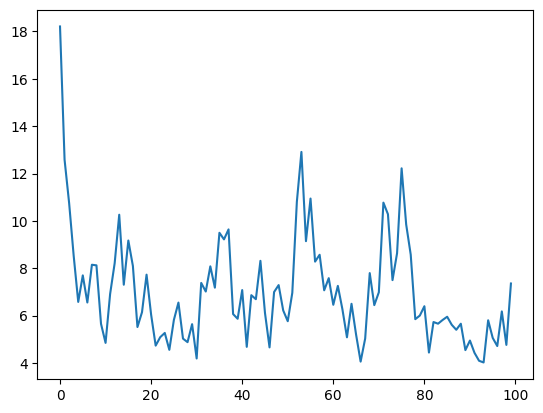

In [73]:
# Train
model.train()
lossi = adam(model, (lambda x, y: MAPE(x, y, mean[:, -2], std[:, -2])), x_train, y_train, LR, LAMBDA_, BATCH_SIZE, STEPS)

# Plot loss
from matplotlib import pyplot as plt
plt.plot(torch.tensor(lossi).view(-1, 10).mean(1))

In [74]:
model.eval()
vals = model.forward(x_train)
percents = (vals.flatten() * std[:, -2] + mean[:, -2]) / 1e4
targs = (y_train.flatten() * std[:, -2] + mean[:, -2]) / 1e4
loss = RMSE(percents, targs)
print(loss.item())
print(MAPE(vals, y_train, mean[:, -2], std[:, -2]).item())

0.0038042773958295584
8.172659873962402


In [75]:
model.eval()
vals = model.forward(x_test)
percents = (vals.flatten() * std[:, -2] + mean[:, -2]) / 1e4
targs = (y_test.flatten() * std[:, -2] + mean[:, -2]) / 1e4
loss = RMSE(percents, targs)
print(loss.item())
print(MAPE(vals, y_test, mean[:, -2], std[:, -2]).item())

0.0002990658686030656
12.8109712600708


In [76]:
print(targs.std().item(), percents.std().item())
print(targs.mean().item(), percents.mean().item())

0.002686969004571438 0.0025924001820385456
0.00327099347487092 0.003275121096521616


Text(0.5, 1.0, 'Target Distribution (Unnormalized)')

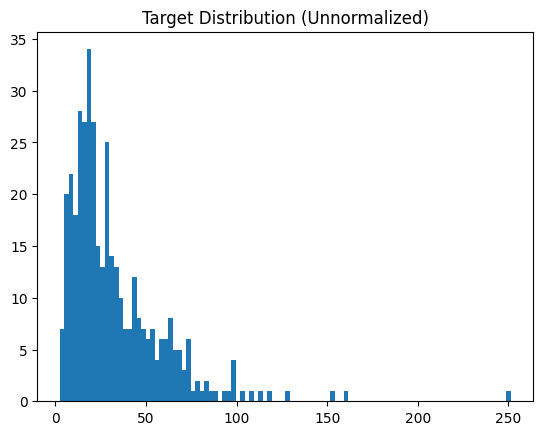

In [77]:
plt.hist((targs * 1e4).numpy(), bins=100)
plt.title("Target Distribution (Unnormalized)")


Text(0.5, 1.0, 'Percent Distribution (Unnormalized)')

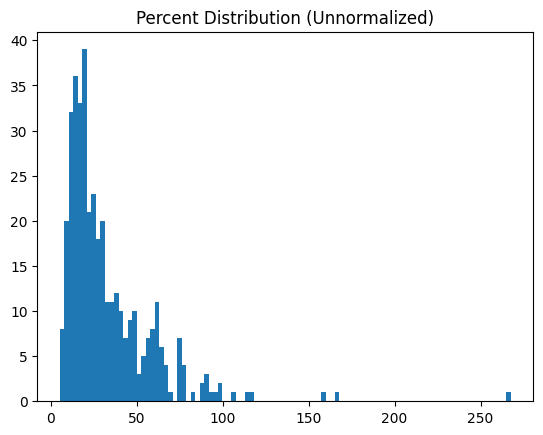

In [78]:
plt.hist((percents*1e4).detach().numpy(), bins=100)
plt.title("Percent Distribution (Unnormalized)")

Text(0, 0.5, 'Absolute Error')

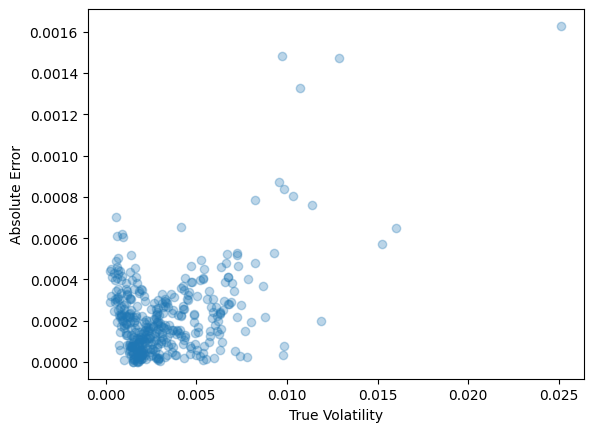

In [79]:
plt.scatter(targs.numpy(), (percents.detach() - targs).abs().numpy(), alpha=0.3)
plt.xlabel("True Volatility")
plt.ylabel("Absolute Error")


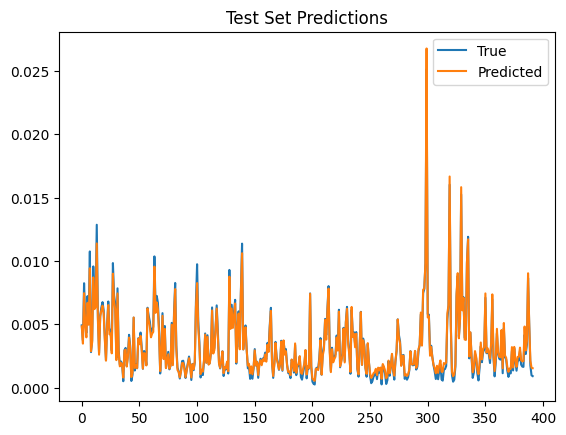

In [80]:
plt.plot(targs.detach(), label="True")
plt.plot(percents.detach(), label="Predicted")
plt.title("Test Set Predictions")
plt.legend()


In [81]:
bins = [0, 0.001, 0.003, 0.01, 0.02, 1.0]
for i in range(len(bins)-1):
    mask = (targs >= bins[i]) & (targs < bins[i+1])
    bin_mape = torch.mean(torch.abs((percents[mask] - targs[mask]) / targs[mask]))
    print(f"MAPE for {bins[i]}–{bins[i+1]}: {bin_mape.item()*100:.2f}%")


MAPE for 0–0.001: 55.64%
MAPE for 0.001–0.003: 8.24%
MAPE for 0.003–0.01: 4.73%
MAPE for 0.01–0.02: 6.83%
MAPE for 0.02–1.0: 6.48%


In [82]:
mask = targs >= 0.003
filtered_mape = torch.mean(torch.abs((percents[mask] - targs[mask]) / targs[mask]))
print("Filtered MAPE (vol ≥ 0.003):", filtered_mape.item() * 100)


Filtered MAPE (vol ≥ 0.003): 4.833116754889488


In [ ]:
# Save model weights
torch.save(model.state_dict(), "../data/model/best_model.pt")

# Save metadata
import json
meta = {
    "mean": mean.tolist(),
    "std": std.tolist(),
    "delta": 3,
    "context": 10,
    "input_size": 28,
    "hidden_size": 32,
    "mlp_size": [32, 1]
}
with open("../data/model/model_meta.json", "w") as f:
    json.dump(meta, f, indent=2)